# Yankees - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 31, 2022

## Hypothesis
We can help teams predict who will buy a single ticket to the next game based on the historical data we have on that fan. This also requires engineering a new feature (isNextGameBuyer) in order to make a prediction on if the fan will buy a ticket to the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

(596781, 45)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596781 entries, 0 to 596780
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lkupClientId            596781 non-null  int64  
 1   dimCustomerMasterId     596781 non-null  int64  
 2   dimEventId              596781 non-null  int64  
 3   inMarket                596781 non-null  bool   
 4   customerNumber          596781 non-null  object 
 5   year                    596781 non-null  int64  
 6   productGrouping         596781 non-null  object 
 7   Tier                    596781 non-null  int64  
 8   totalSpent              596781 non-null  float64
 9   recentDate              596781 non-null  object 
 10  attendancePercent       596781 non-null  float64
 11  renewedBeforeDays       596781 non-null  int64  
 12  isBuyer                 596781 non-null  object 
 13  source_tenure           596781 non-null  int64  
 14  tenure              

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "inMarket",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "Tier",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
#df_dataset = df_dataset[df_dataset["Tier"] == {1,2,3} ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (454560, 19)
Unseen Data For Predictions: (80217, 19)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="Tier", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=["inMarket",
        "attendancePercent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.5945,0.6969,0.4649,0.6093,0.5674,0.2434,0.2613,30.4260
lightgbm,Light Gradient Boosting Machine,0.5883,0.6894,0.4559,0.6065,0.5578,0.2285,0.2489,2.4870
rf,Random Forest Classifier,0.5667,0.6586,0.4602,0.5585,0.5535,0.2147,0.2181,19.7680
gbc,Gradient Boosting Classifier,0.5579,0.6424,0.4112,0.5801,0.5160,0.1617,0.1812,42.7720
lr,Logistic Regression,0.5126,0.5584,0.3540,0.4703,0.4331,0.0525,0.0709,20.8290


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5965,0.6968,0.4670,0.6117,0.5695,0.2472,0.2653
1,0.5969,0.6978,0.4670,0.6143,0.5697,0.2472,0.2658
2,0.5943,0.6964,0.4627,0.6101,0.5658,0.2417,0.2608
3,0.5960,0.6987,0.4656,0.6095,0.5695,0.2469,0.2639
4,0.5955,0.6979,0.4654,0.6095,0.5685,0.2454,0.2630
5,0.5952,0.6981,0.4645,0.6074,0.5678,0.2448,0.2630
6,0.5958,0.6994,0.4657,0.6135,0.5678,0.2448,0.2640
7,0.5923,0.6958,0.4653,0.6078,0.5659,0.2398,0.2570
8,0.5929,0.6973,0.4646,0.6065,0.5668,0.2413,0.2579
9,0.5899,0.6909,0.4614,0.6029,0.5631,0.2353,0.2519


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(62004, 45)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,dimEventId,inMarket,customerNumber,year,productGrouping,Tier,totalSpent,recentDate,...,phonecall,text,unknown,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer,Label,Score_1,Score_2,Score_3
534777,53,9,96,True,10212779,2021,Online Individual Game,2,230.0,2021-08-17,...,0,0,0,0.0,94,0,1,0.8312,0.1319,0.0368
534778,53,876,1278,False,26780186,2021,Online Individual Game,2,210.0,2021-07-04,...,0,0,0,0.0,94,0,1,0.8661,0.0873,0.0466
534779,53,1353,1255,False,25329442,2021,Other,2,8.0,1970-01-01,...,0,0,0,0.0,94,0,3,0.0193,0.2708,0.7099
534780,53,2586,102,False,13241926,2021,Online Individual Game,3,280.0,2021-08-18,...,0,0,0,0.0,94,0,3,0.2000,0.3593,0.4407
534781,53,4669,96,True,23839189,2021,Online Individual Game,2,0.0,1970-01-01,...,0,0,0,0.0,94,0,3,0.0673,0.4176,0.5151


In [11]:
new_predictions["Label"].value_counts()

2    30993
1    16748
3    14263
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    34223
(0.2, 0.4]        9237
(0.4, 0.6]        7714
(0.6, 0.8]        5999
(0.8, 1.0]        4831
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

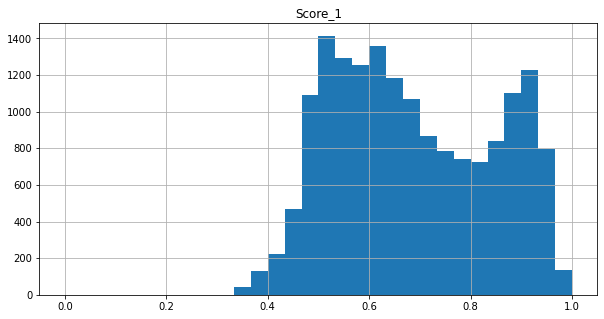

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

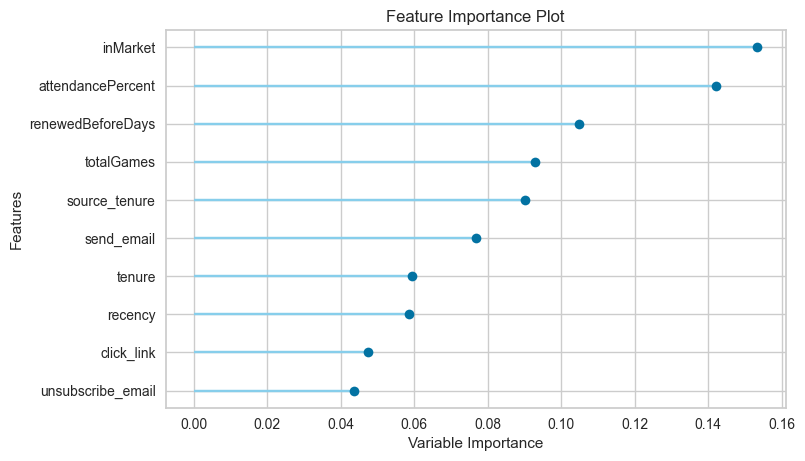

In [14]:
plot_model(best_model, plot='feature')

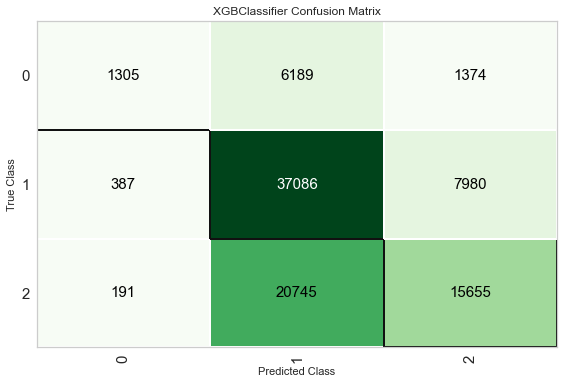

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* The distribtution looks normal (as expected)
* Ticketing data is still the first 4 features
* Makerketing data follows up at the next 4 features
* The model makes a lot more predictions of customers who won't buy

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.